In [ ]:
import cv2
from utils import *
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
img = cv2.imread("../data/plantvillage/Septoria_leaf_spot/002533c1-722b-44e5-9d2e-91f7747b2543___Keller.St_CG 1831.JPG")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_sharpen = lapacian_detection_2(img)

fig = plt.figure(figsize=(10, 20))
ax1, ax2, ax3 = fig.subplots(1, 3)

ax1.imshow(img[:, :, ::-1])
ax2.imshow(img_gray)
ax3.imshow(img_sharpen[:, :, ::-1])
plt.show()

# I. Image Preprocessing

## 1.1 Xử lý dữ liệu imbalance
* Bằng các làm giàu thêm dữ liệu từ các tập dữ liệu đang có sẵn

In [ ]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from skimage.feature import hog
from numpy import linalg as LA
from fcmeans import FCM

import os
import glob
import gc

# example of zoom image augmentation
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator

import shutil
import random
from tqdm import tqdm
import time

In [ ]:
def generator_image(image, method_transform): 
    data = np.copy(image)

    # expand dimension to one sample
    samples = expand_dims(data, 0)

    # create image data augmentation generator
    datagen = method_transform

    # prepare iterator
    it = datagen.flow(samples, batch_size=1)
    new_image = it.next()[0].astype('uint8')

    # save new generator image
    return new_image

In [ ]:
datagen = ImageDataGenerator(
    fill_mode='constant',    # Tự động thêm các giá trị 0
    rotation_range=90, 
    zoom_range=[0.7, 1.0], 
    horizontal_flip=True, 
    vertical_flip=True, 
    brightness_range=[0.7,1.3], 
    width_shift_range=0.2, height_shift_range=0.2)

## 1.2 Phân đoạn và tăng cường ảnh

#### Segmentaion
* Note: Cần thêm bước cân bằng sáng, cân bằng constract, cân bằng histogram trước khi đưa vào segmentation
* https://stackoverflow.com/questions/54723141/segmentation-problem-for-tomato-leaf-images-in-plantvillage-dataset

In [ ]:
# Hàm thực hiện phân đoạn bức ảnh
# Remove background
def segmentation_leaf(image, fuzzy_mean_c=8): 
    # Ảnh truyền vào là ảnh 3 kênh
    image_copy = np.copy(image)
    
    # create hsv
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

     # set lower and upper color limits
    low_val = (0,60,0)
    high_val = (179,255,255)

    # Threshold the HSV image 
    mask = cv2.inRange(hsv, low_val,high_val)

    # remove noise
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((8,8),dtype=np.uint8))

    # apply mask to original image
    bg_remove_img = cv2.bitwise_and(image, image,mask=mask)
    
    # sharpen image
    laplacian_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpen_img = cv2.filter2D(src=bg_remove_img, ddepth=-1, kernel=laplacian_filter)

    # remove noise mà vẫn giữ được biên
    rm_noise_img = cv2.bilateralFilter(sharpen_img, 15, 75, 75)

    # Fuzzy C Mean
    X = rm_noise_img.reshape(-1, 3)
    fcm = FCM(n_clusters=fuzzy_mean_c, random_state=1024)
    fcm.fit(X)
    label = fcm.predict(X)
    fuzzy_mean_image = label.reshape(rm_noise_img.shape[:2])
    
    # Ảnh 1 chiều
    return fuzzy_mean_image

In [ ]:
# Sharpen image and remove noise


In [ ]:
# load image
from utils import *
image = cv2.imread('../data/plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG')

bg_remove_img = remove_background(image)

# sharpen image
# laplacian_filter = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
# sharpen_img = cv2.filter2D(src=bg_remove_img, ddepth=-1, kernel=laplacian_filter)

sharpen_img = lapacian_detection(bg_remove_img)

# remove noise mà vẫn giữ được biên
# rm_noise_img = cv2.bilateralFilter(sharpen_img, 15, 75, 75)

# Fuzzy C Mean
X = rm_noise_img.reshape(-1, 3)
fcm = FCM(n_clusters=8, random_state=0)
fcm.fit(X)
label = fcm.predict(X)
fuzzy_mean_image = label.reshape(rm_noise_img.shape[:2])
display(np.unique(fuzzy_mean_image, return_counts=True), fuzzy_mean_image.shape)

#show image
fig = plt.figure(figsize=(20, 10))
(ax1, ax2 , ax3), (ax4, ax5, ax6) = fig.subplots(2, 3)

ax1.imshow(image[:, :, ::-1])
# ax2.imshow(None)
ax3.imshow(bg_remove_img[:,:, ::-1])

ax4.imshow(sharpen_img[:, :, ::-1])
ax5.imshow(rm_noise_img[:, :, ::-1])
ax6.imshow(fuzzy_mean_image, cmap="gray")

plt.show()

### Note

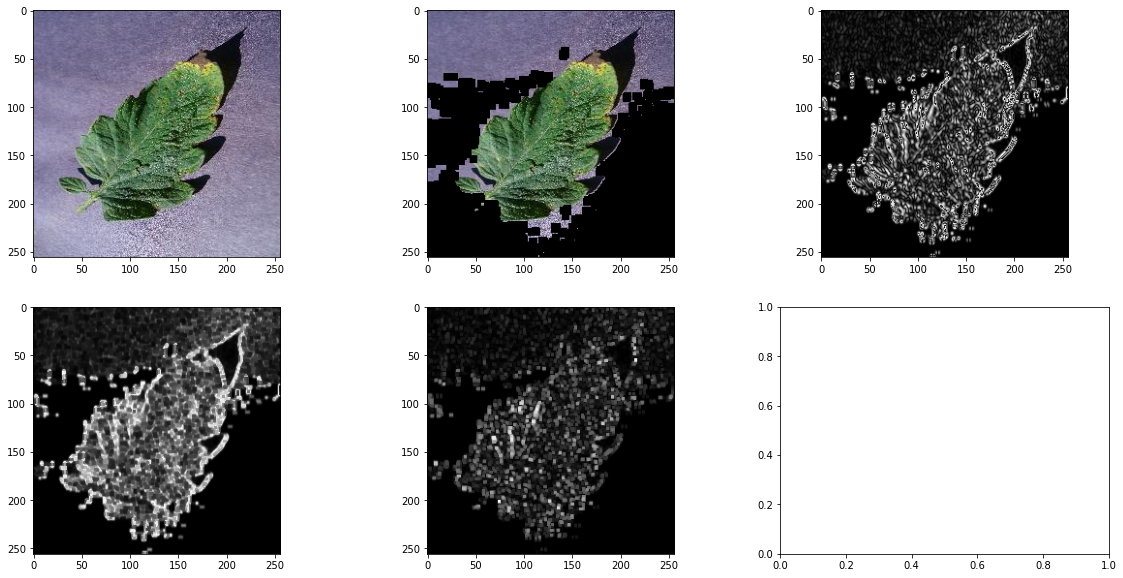

In [11]:
from utils import *
from fcmeans import FCM
import numpy as np
from matplotlib import pyplot as plt

# image = cv2.imread('../data/plantvillage/Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG')
image = cv2.imread('../data/plantvillage/Septoria_leaf_spot/0176f68f-a3d8-473b-9bea-c075a5507b34___JR_Sept.L.S 2504.JPG')

bg_remove_img = remove_background(image)

sharpen_img = sobel_edge_detection_2(cv2.cvtColor(bg_remove_img, cv2.COLOR_BGR2GRAY))

kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(sharpen_img, cv2.MORPH_CLOSE, kernel)
opening = cv2.morphologyEx(sharpen_img, cv2.MORPH_OPEN, kernel)

# fcm_img = fcm_image(remove_noise_img, n_cluster=20)

#show image
fig = plt.figure(figsize=(20, 10))
(ax1, ax2, ax3) ,(ax4, ax5, ax6) = fig.subplots(2, 3)

ax1.imshow(image[:, :, ::-1])
ax2.imshow(bg_remove_img[:,:, ::-1])
ax3.imshow(sharpen_img, cmap="gray")
ax4.imshow(closing, cmap="gray")
ax5.imshow(opening, cmap="gray")

In [12]:
import cv2
import numpy as np

image = cv2.imread('../data/plantvillage/Late_blight/005a2c1f-4e15-49e4-9e5c-61dc3ecf9708___RS_Late.B 5096.JPG')
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

img_lap = cv2.Laplacian(img_gray, cv2.CV_64F, ksize=3, scale=1)
print(f"Min: {np.min(img_lap)}, max: {np.max(img_lap)}")

cv2.normalize(img_lap, img_lap, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
print(f"Min: {np.min(img_lap)}, max: {np.max(img_lap)}")


Min: -1388.0, max: 978.0
Min: -1388.0, max: 978.0


In [12]:
import numpy as np
from fcmeans import FCM

n_samples = 3000

X = np.concatenate((
    np.random.normal((-2, -2), size=(n_samples, 2)),
    np.random.normal((2, 2), size=(n_samples, 2))
))

X.shape

(6000, 2)

In [ ]:
!ls plantvillage/

# II. Các phương pháp trích chọn đặc trưng của ảnh
* Sử dụng kết hợp các phương pháp
1.   Color features: dùng histogram
2.   Shape features: dùng hu-moments
3.   Texture features: dùng Haralick features (GLCM)

## 2.1 HOG 
Link tài liệu tham khảo:
* https://minhng.info/tutorials/histograms-of-oriented-gradients.html
* https://www.thepythoncode.com/article/hog-feature-extraction-in-python


### Sử dụng thư viện của opencv

In [ ]:
image = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")
# resized_img = cv2.resize(image, dsize=(64, 128))

plt.axis("off")
plt.imshow(image[:, :, ::-1])
plt.show()

In [ ]:
fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
display(fd, fd.shape)
plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()

### Hàm tự cài đặt

In [ ]:
# https://minhng.info/tutorials/histograms-of-oriented-gradients.html
def hog(img_gray, cell_size=8, block_size=2, bins=9):
    img = img_gray
    h, w = img.shape # 128, 64
    
    # gradient
    xkernel = np.array([[-1, 0, 1]])
    ykernel = np.array([[-1], [0], [1]])
    dx = cv2.filter2D(img, cv2.CV_32F, xkernel)
    dy = cv2.filter2D(img, cv2.CV_32F, ykernel)
    
    # histogram
    magnitude = np.sqrt(np.square(dx) + np.square(dy))
    orientation = np.arctan(np.divide(dy, dx+0.00001)) # radian
    orientation = np.degrees(orientation) # -90 -> 90
    orientation += 90 # 0 -> 180
    
    num_cell_x = w // cell_size # 8
    num_cell_y = h // cell_size # 16
    hist_tensor = np.zeros([num_cell_y, num_cell_x, bins]) # 16 x 8 x 9
    for cx in range(num_cell_x):
        for cy in range(num_cell_y):
            ori = orientation[cy*cell_size:cy*cell_size+cell_size, cx*cell_size:cx*cell_size+cell_size]
            mag = magnitude[cy*cell_size:cy*cell_size+cell_size, cx*cell_size:cx*cell_size+cell_size]
            # https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html
            hist, _ = np.histogram(ori, bins=bins, range=(0, 180), weights=mag) # 1-D vector, 9 elements
            hist_tensor[cy, cx, :] = hist
        pass
    pass
    
    # normalization
    redundant_cell = block_size-1
    feature_tensor = np.zeros([num_cell_y-redundant_cell, num_cell_x-redundant_cell, block_size*block_size*bins])
    for bx in range(num_cell_x-redundant_cell): # 7
        for by in range(num_cell_y-redundant_cell): # 15
            by_from = by
            by_to = by+block_size
            bx_from = bx
            bx_to = bx+block_size
            v = hist_tensor[by_from:by_to, bx_from:bx_to, :].flatten() # to 1-D array (vector)
            feature_tensor[by, bx, :] = v / LA.norm(v, 2)
            # avoid NaN:
            if np.isnan(feature_tensor[by, bx, :]).any(): # avoid NaN (zero division)
                feature_tensor[by, bx, :] = v
    
    return feature_tensor.flatten() # 3780 features

In [ ]:
image = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")
resized_img = cv2.resize(image, dsize=(64, 128))

plt.axis("off")
plt.imshow(image[:, :, ::-1])
plt.show()

In [ ]:
fd = hog(cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY))

display(fd, fd.shape)

## 2.2 LBP
Link tài liệu tham khảo: 
* https://minhng.info/tutorials/local-binary-patterns-lbp-opencv.html

In [ ]:
from skimage.feature import local_binary_pattern # # pip install scikit-image

img = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")
pattern = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

out_scikit = local_binary_pattern(image=pattern, P=8, R=1, method='default')

In [ ]:
out_scikit, out_scikit.shape

## 2.3 Hu Moments
Tài liệu tham khảo: 
* https://learnopencv.com/shape-matching-using-hu-moments-c-python/


In [ ]:
import math

In [ ]:
img = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Calculate Moments
moments = cv2.moments(gray)
# Calculate Hu Moments
huMoments = cv2.HuMoments(moments).flatten()

# Log scale hu moments
for i in range(0, 7):
    huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))

# Giá trị sau cùng cần được chuẩn hóa
display(huMoments)

In [ ]:
# Trích xuất thông tin xử dụng phương pháp hu_moments
def hu_moments_feature(gray_image):
    gray = np.copy(gray_image)

    # Calculate Moments
    moments = cv2.moments(gray)
    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments).flatten()

    # Log scale hu moments
    for i in range(0,7):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]))    

    return huMoments

In [ ]:
img = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

hu_moments_feature(gray)

## 2.4 Haralick Features (GLCM)
Tài liệu tham khảo: 
* https://gogul.dev/software/texture-recognition#:~:text=Haralick%20Texture%20is%20used%20to,Co%2Doccurrence%20Matrix%20or%20GLCM.
* https://gogul.dev/software/texture-recognition
* https://github.com/alfianhid/Feature-Extraction-Gray-Level-Co-occurrence-Matrix-GLCM-with-Python/blob/master/Feature_Extraction_Gray_Level_Co_occurrence_Matrix_(GLCM)_with_Python.ipynb

In [ ]:
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics.cluster import entropy as compute_entropy

In [ ]:
def glcm_feature(gray_image):
    image = np.copy(gray_image)

    # 1. compute entropy
    entropy = compute_entropy(image)

    # khỏi tạo ma trận mức xám GLCM
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255]) #16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max()+1
    # Các góc phi là 0, 45, 90, 135
    matrix_coocurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=True, symmetric=True)

     # 2. compute contract
    contrast = np.mean(graycoprops(matrix_coocurrence, 'contrast'))

    # 3. compute dissimilarity
    dissimilarity = np.mean(graycoprops(matrix_coocurrence, 'dissimilarity'))

    # 4. compute homogeneity
    homogeneity = np.mean(graycoprops(matrix_coocurrence, 'homogeneity'))

    # 5. compute energy
    energy = np.mean(graycoprops(matrix_coocurrence, 'energy'))

    # 6. compute correlation
    correlation = np.mean(graycoprops(matrix_coocurrence, 'correlation'))

    # 7. compute ASM
    asm = np.mean(graycoprops(matrix_coocurrence, 'ASM'))

    return entropy, contrast, dissimilarity, homogeneity, energy, correlation, asm


In [ ]:
gray_img = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG", 0)

glcm_feature(gray_img)

## 2.5 Histogram Feature Extraction

In [ ]:
def histogram_feature(gray_image, bins=10, range=[0, 256]):
    gray = np.copy(gray_image)

    hists, _ = np.histogram(gray, bins=bins, range=range)

    return hists

In [ ]:
gray = cv2.imread("./plantvillage/Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG", 0)

histogram_feature(gray, bins=255, range=[1, 256]).shape

# III. Xuất dữ liệu ra file .csv
* Trích xuất đặc trưng đưa vào file .csv
* Thực hiện MinMaxScaler, OneHotVector cho label

In [ ]:
columns_name = ["path",
                # "hist_0", "hist_1", "hist_2", "hist_3", "hist_4", "hist_5","hist_6", "hist_7", "hist_8", "hist_9",
                # "hu_moment_h1", "hu_moment_h2", "hu_moment_h3", "hu_moment_h4", "hu_moment_h5", "hu_moment_h6", "hu_moment_h7", 
                "glcm_entropy", "glcm_contract", "glcm_dissimilarity", "glcm_homogeneity", "glcm_energy", "glcm_correlation", "glcm_asm", 
                "label"]
df = pd.DataFrame(columns=columns_name)

In [ ]:
def create_new_row(path, hists, hu_moments, glcms, label):
    return {
        "path": path, 
        # "hist_0": hists[0], 
        # "hist_1": hists[1], 
        # "hist_2": hists[2], 
        # "hist_3": hists[3], 
        # "hist_4": hists[4], 
        # "hist_5": hists[5],
        # "hist_6": hists[6], 
        # "hist_7": hists[7], 
        # "hist_8": hists[8], 
        # "hist_9": hists[9],
        # "hu_moment_h1": hu_moments[0], 
        # "hu_moment_h2": hu_moments[1], 
        # "hu_moment_h3": hu_moments[2], 
        # "hu_moment_h4": hu_moments[3], 
        # "hu_moment_h5": hu_moments[4], 
        # "hu_moment_h6": hu_moments[5], 
        # "hu_moment_h7": hu_moments[6], 
        "glcm_entropy": glcms[0], 
        "glcm_contract": glcms[1], 
        "glcm_dissimilarity": glcms[2], 
        "glcm_homogeneity": glcms[3], 
        "glcm_energy": glcms[4], 
        "glcm_correlation": glcms[5], 
        "glcm_asm": glcms[6],                 
        "label": label
    }

In [ ]:
# data generator
data_path = f"./data2/"
max_data = 2000

for subdir in os.listdir(data_path):
    
    file_names = glob.glob(f"{os.path.join(data_path, subdir)}/**")
    
    count = 0
    len_max = len(file_names)

    for i in tqdm(range(max_data), desc=f"{subdir}"):
        if count >= len_max: 
            # Gen data
            # random index
            idx_rand = random.randint(0, len_max - 1)
            path_image = file_names[idx_rand]
            image = cv2.imread(path_image)

            # create new image, write to folder
            new_image = generator_image(
                image=image, 
                method_transform=datagen
            )
            
            # Tạo segmentation
            new_image_seg = segmentation_leaf(new_image)
            
            # Chuyển sang hệ màu gray
            gray_image = cv2.cvtColor(new_image_seg, cv2.COLOR_BGR2GRAY)

            # Có thể xử lý dữ liệu trích xuất đặc trưng đưa vào file data
            df = df.append(
                # Trích xuất đặc trưngl
                create_new_row(
                    path_image,
                    histogram_feature(gray_image, bins=10, range=[1, 256]),
                    hu_moments_feature(gray_image), 
                    glcm_feature(gray_image), 
                    subdir
                ), 
                ignore_index=True
            )      

        else: 
            # copy data
            path_image = file_names[i]
            
            # đọc ảnh
            image = cv2.imread(path_image)
            
            # tạo segmentation 
            new_image_seg = segmentation_leaf(image)
            
            #chuyển sang hệ màu gray
            gray_image = cv2.cvtColor(new_image_seg, cv2.COLOR_BGR2GRAY)

            # Có thể xử lý dữ liệu trích xuất đặc trưng đưa vào file data
            df = df.append(
                # Trích xuất đặc trưng
                create_new_row(
                    path_image,
                    histogram_feature(gray_image, bins=10, range=[1, 256]),
                    hu_moments_feature(gray_image), 
                    glcm_feature(gray_image),  
                    subdir
                ), 
                ignore_index=True
            )

        count += 1

        if i % 100 == 0: 
            gc.collect()

In [ ]:
# data generator
data_path = f"./plantvillage/"

for subdir in os.listdir(data_path):
    
    file_names = glob.glob(f"{os.path.join(data_path, subdir)}/**")
    len_file = len(file_names)
    
    for i in tqdm(range(len_file), desc=f"{subdir}"):
        path_image = file_names[i]

        # đọc ảnh
        image = cv2.imread(path_image)

        # tạo segmentation 
        new_image_seg = segmentation_leaf(image)

        # chuyển sang hệ màu gray
        # gray_image = cv2.cvtColor(new_image_seg, cv2.COLOR_BGR2GRAY)

        # Có thể xử lý dữ liệu trích xuất đặc trưng đưa vào file data
        df = df.append(
            # Trích xuất đặc trưng
            create_new_row(
                path_image,
                None, # histogram_feature(new_image_seg, bins=10, range=[1, 256]),
                None, # hu_moments_feature(new_image_seg), 
                glcm_feature(new_image_seg),  
                subdir
            ), 
            ignore_index=True
        )

        if i % 100 == 0: 
            gc.collect()

In [ ]:
df["label"]

In [ ]:
df.to_csv("./datagen/data_preprocessing.csv")

* Thực hiện MinMaxScaler và chuyển label thành OneHotVector

In [ ]:
train = pd.read_csv("./datagen/data_preprocessing.csv")

In [ ]:
# shuffle index
train = train.sample(frac=1).reset_index(drop=True)
train  # .csv

In [ ]:
train.columns

In [ ]:
train.drop(columns=["path", "Unnamed: 0"], inplace=True)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()

# train[['hist_0', 'hist_1', 'hist_2', 'hist_3', 'hist_4',
#        'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hu_moment_h1',
#        'hu_moment_h2', 'hu_moment_h3', 'hu_moment_h4', 'hu_moment_h5',
#        'hu_moment_h6', 'hu_moment_h7', 'glcm_entropy', 'glcm_contract',
#        'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy',
#        'glcm_correlation', 'glcm_asm']] = \
# scaler.fit_transform(train[['hist_0', 'hist_1', 'hist_2', 'hist_3', 'hist_4',
#        'hist_5', 'hist_6', 'hist_7', 'hist_8', 'hist_9', 'hu_moment_h1',
#        'hu_moment_h2', 'hu_moment_h3', 'hu_moment_h4', 'hu_moment_h5',
#        'hu_moment_h6', 'hu_moment_h7', 'glcm_entropy', 'glcm_contract',
#        'glcm_dissimilarity', 'glcm_homogeneity', 'glcm_energy',
#        'glcm_correlation', 'glcm_asm']])

In [ ]:
# Onehot vector cho label
# y_label = train["label"].values

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# onehot = OneHotEncoder()
# y_onehot = onehot.fit_transform(y_label.reshape(-1, 1))

# y_array = y_onehot.toarray()

In [ ]:
# y_array.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder() 
  
y_array = le.fit_transform(train['label'])
le.classes_

In [ ]:
X = train.drop(columns=["label"]).values
X.shape

In [ ]:
# Split train test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_array, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# IV. Model train và đánh giá

## 1. KNN

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

In [ ]:
y_pre = neigh.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pre)}")
print(classification_report(y_test, y_pre))
plot_confusion_matrix(neigh, X_test, y_test)

## 2. Decision Tree

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model_tree = DecisionTreeClassifier(random_state=42)
model_tree.fit(X_train, y_train)

In [ ]:
y_pre = model_tree.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pre)}")
print(classification_report(y_test, y_pre))
plot_confusion_matrix(model_tree, X_test, y_test)

## 3. Random Forest

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

forest = RandomForestClassifier(n_estimators=100, class_weight="balanced_subsample")
forest.fit(X_train, y_train)

In [ ]:
y_pre = forest.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pre)}")
print(classification_report(y_test, y_pre))
plot_confusion_matrix(forest, X_test, y_test)

## 4. SVM

In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

In [ ]:
y_pre = clf.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pre)}")
print(classification_report(y_test, y_pre))
plot_confusion_matrix(clf, X_test, y_test)

## 5. XGBoot

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBClassifier(random_state=42, n_estimators=100)
model_xgb.fit(X_train, y_train)

In [ ]:
y_pre = model_xgb.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pre)}")
print(classification_report(y_test, y_pre))
plot_confusion_matrix(model_xgb, X_test, y_test)

## 6. Deep Learing

In [ ]:
DATASET="./data3/train"
DATASET2="./data3/valid"

CATEGORIES=[
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]
        
train_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(64,64))            
            train_data.append([img,label])
            
test_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET2,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(64,64))
            test_data.append([img,label])
            
print(len(train_data))
print(len(test_data))

In [ ]:
import random

random.shuffle(train_data)
random.shuffle(test_data)

for lbl in train_data[:10]:
    print(lbl[1])
    
X_train=[]
y_train=[]

for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

Y=[]
for i in y_train:
    if i==0:
        Y.append("BACTERIAL SPOT")
    elif i==1:
        Y.append("EARLY BLIGHT")
    elif i==2:
        Y.append("HEALTHY")
    elif i==3:
        Y.append("LATE BLIGHT")
    elif i==4:
        Y.append("LEAF MOLD")
    elif i==5:
        Y.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Y.append("SPIDER MITE")
    elif i==7:
        Y.append("TARGET SPOT")
    elif i==8:
        Y.append("MOSAIC VIRUS")
    else:
        Y.append("YELLOW LEAF CURL VIRUS")

len(X_train),len(y_train)

X_test=[]
y_test=[]

for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
    
Z=[]
for i in y_test:
    if i==0:
        Z.append("BACTERIAL SPOT")
    elif i==1:
        Z.append("EARLY BLIGHT")
    elif i==2:
        Z.append("HEALTHY")
    elif i==3:
        Z.append("LATE BLIGHT")
    elif i==4:
        Z.append("LEAF MOLD")
    elif i==5:
        Z.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Z.append("SPIDER MITE")
    elif i==7:
        Z.append("TARGET SPOT")
    elif i==8:
        Z.append("MOSAIC VIRUS")
    else:
        Z.append("YELLOW LEAF CURL VIRUS")

len(X_test),len(y_test)

X_train=np.array(X_train).reshape(-1,64,64,3)
X_train=X_train/255.0
X_train.shape

X_test=np.array(X_test).reshape(-1,64,64,3)
X_test=X_test/255.0
X_test.shape

In [ ]:
order=['BACTERIAL SPOT','EARLY BLIGHT','HEALTHY','LATE BLIGHT','LEAF MOLD','SEPTORIA LEAF SPOT','SPIDER MITE','TARGET SPOT','MOSAIC VIRUS','YELLOW LEAF CURL VIRUS']

ax=sns.countplot(Y, order=order)
ax.set_xlabel("Leaf Diseases")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel("Image Count")

ax=sns.countplot(Z, order=order)
ax.set_xlabel("Leaf Diseases")
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel("Image Count")

In [ ]:
from keras.utils import to_categorical

one_hot_train=to_categorical(y_train)
one_hot_train

one_hot_test=to_categorical(y_test)
one_hot_test

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,MaxPooling2D,Dropout

classifier=Sequential()

classifier.add(Conv2D(32,(3,3), input_shape=(64,64,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(128,(3,3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2,2)))
classifier.add(Dropout(0.4))

classifier.add(Flatten())

classifier.add(Dense(activation='relu', units=64))
classifier.add(Dense(activation='relu', units=128))
classifier.add(Dense(activation='relu', units=64))
classifier.add(Dense(activation='softmax', units=10))

classifier.summary()

In [ ]:
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
hist=classifier.fit(X_train,one_hot_train,epochs=75,batch_size=128,validation_split=0.2)

In [ ]:
test_loss,test_acc=classifier.evaluate(X_test,one_hot_test)
test_loss,test_acc

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper right')
plt.show()

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [ ]:
y_pred=classifier.predict_classes(X_test)
y_pred

In [ ]:
y_prob=classifier.predict_proba(X_test)
y_prob

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
thresh ={}
roc_auc={}

n_class = 10

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
      
plt.plot(fpr[0], tpr[0], color='orange',label='Bacterial Spot AUC = %0.3f' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green',label='Early Blight AUC = %0.3f' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue',label='Healthy AUC = %0.3f' % roc_auc[2])
plt.plot(fpr[3], tpr[3], color='red',label='Late Blight AUC = %0.3f' % roc_auc[3])
plt.plot(fpr[4], tpr[4], color='pink',label='Leaf Mold AUC = %0.3f' % roc_auc[4])
plt.plot(fpr[5], tpr[5], color='purple',label='Septoria Leaf Spot AUC = %0.3f' % roc_auc[5])
plt.plot(fpr[6], tpr[6], color='brown',label='Spider Mites AUC = %0.3f' % roc_auc[6])
plt.plot(fpr[7], tpr[7], color='cyan',label='Target Spot AUC = %0.3f' % roc_auc[7])
plt.plot(fpr[8], tpr[8], color='yellow',label='Mosaic Virus AUC = %0.3f' % roc_auc[8])
plt.plot(fpr[9], tpr[9], color='black',label='Yellow Leaf Curl Virus AUC = %0.3f' % roc_auc[9])
plt.title('Tomato Leaves Diseases ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')

In [ ]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)

In [ ]:
import cv2
import matplotlib.pyplot as plt
from feature_extraction import histogram_feature

In [ ]:
img = cv2.imread("../data/plantvillage/Tomato___Bacterial_spot/00416648-be6e-4bd4-bc8d-82f43f8a7240___GCREC_Bact.Sp 3110.JPG", 0)

a = histogram_feature(img)